<a href="https://colab.research.google.com/github/ads-predict-early-alzheimers/project/blob/main/project_part_1_privacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alzheimer's prediction protection

## What is Alzheimer's disease (AD)?

Alzheimer's disease (AD) is a neurodegenerative disease that usually starts slowly and progressively worsens.It is the cause of 60–70% of cases of dementia.The most common early symptom is difficulty in remembering recent events. As the disease advances, symptoms can include problems with language, disorientation (including easily getting lost), mood swings, loss of motivation, self-neglect, and behavioral issues. As a person's condition declines, they often withdraw from family and society.Gradually, bodily functions are lost, ultimately leading to death. Although the speed of progression can vary, the typical life expectancy following diagnosis is three to nine years.

## What is Dementia?

Dementia is a general term for loss of memory, language, problem-solving and other thinking abilities that are severe enough to interfere with daily life. Alzheimer's is the most common cause of dementia, a general term for memory loss and other cognitive abilities serious enough to interfere with daily life. Alzheimer's disease accounts for 60-80% of dementia cases.

### Our problem statement

Estimating the CDR (scale of Dementia) using relevant features in the MRI dataset.

The CDR is based on a scale of 0–3: no dementia (CDR = 0), questionable dementia (CDR = 0.5), MCI (CDR = 1), moderate cognitive impairment (CDR = 2), and severe cognitive impairment (CDR = 3).

In [1]:
import tensorflow.compat.v1 as tf
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy.io import loadmat
import os
from pywt import wavedec
from functools import reduce
from scipy import signal
from scipy.stats import entropy
from scipy.fft import fft, ifft
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow import keras as K
import matplotlib.pyplot as plt
import scipy
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold,cross_validate
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt;
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from tensorflow.keras.layers import Conv1D,Conv2D,Add
from tensorflow.keras.layers import MaxPool1D, MaxPooling2D
import seaborn as sns

## Reading the Cross-sectional and Longitudinal MRI datasets.

We describe the attributes in the dataset with data_cross.info() and data_long.info()

In [2]:
import requests
import pandas as pd
import io

url = 'https://raw.githubusercontent.com/ads-predict-early-alzheimers/project/main/oasis_cross-sectional.csv'
response = requests.get(url)
assert response.status_code == 200, f"Failed to download the CSV file: {response.text}"

cross_content = response.content.decode('utf-8')
data_cross = pd.read_csv(io.StringIO(cross_content))

# Now, you have the CSV data in a pandas DataFrame called `data`


In [3]:
import requests
import pandas as pd

url = 'https://raw.githubusercontent.com/ads-predict-early-alzheimers/project/main/oasis_longitudinal.csv'
response = requests.get(url)
assert response.status_code == 200, f"Failed to download the CSV file: {response.text}"

long_content = response.content.decode('utf-8')
data_long = pd.read_csv(io.StringIO(long_content))

# Now, you have the CSV data in a pandas DataFrame called `data`


In [4]:
print(data_cross.info())
print(data_long.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   M/F     436 non-null    object 
 2   Hand    436 non-null    object 
 3   Age     436 non-null    int64  
 4   Educ    235 non-null    float64
 5   SES     216 non-null    float64
 6   MMSE    235 non-null    float64
 7   CDR     235 non-null    float64
 8   eTIV    436 non-null    int64  
 9   nWBV    436 non-null    float64
 10  ASF     436 non-null    float64
 11  Delay   20 non-null     float64
dtypes: float64(7), int64(2), object(3)
memory usage: 41.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 

## Checking for null values.

In [5]:
print(data_cross.isna().sum())
print("\n")
data_long.isna().sum()

ID         0
M/F        0
Hand       0
Age        0
Educ     201
SES      220
MMSE     201
CDR      201
eTIV       0
nWBV       0
ASF        0
Delay    416
dtype: int64




Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

Since we will be predicting on the variable "CDR", we drop all the rows with undefined or null values

In [6]:
data_cross.dropna(subset=['CDR'],inplace=True)

## Removing unnecessary columns in both datasets.
The unique columns would be of no use in estimating the dependent variable "CDR"

In [7]:
data_cross.drop(columns=['ID','Delay'],inplace=True)
data_long = data_long.rename(columns={'EDUC':'Educ'})
data_long.drop(columns=['Subject ID','MRI ID','Group','Visit','MR Delay'],inplace=True)

## Appending both the datasets.

In [8]:
data = pd.concat([data_cross,data_long])
data.to_csv('combined.csv', index=False)
data.head()

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
8,M,R,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
9,F,R,52,3.0,2.0,30.0,0.0,1321,0.827,1.329


In [9]:
data.describe()

,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
count,608.000000,608.000000,570.00000,606.000000,608.000000,608.000000,608.00000,608.000000
mean,75.208882,10.184211,2.47193,27.234323,0.288651,1477.062500,0.73713,1.203597
std,9.865026,6.058388,1.12805,3.687980,0.377697,170.653795,0.04267,0.135091
min,33.000000,1.000000,1.00000,4.000000,0.000000,1106.000000,0.64400,0.876000
25%,70.000000,4.000000,2.00000,26.000000,0.000000,1352.500000,0.70400,1.118000
50%,76.000000,12.000000,2.00000,29.000000,0.000000,1460.000000,0.73600,1.202000
75%,82.000000,16.000000,3.00000,30.000000,0.500000,1569.000000,0.76625,1.297500
max,98.000000,23.000000,5.00000,30.000000,2.000000,2004.000000,0.84700,1.587000


DATA EDA TO UNDERSTAND BASIC STASTICS AND DISTRIBUTIONS OF THE DATASET. 

This is the first step in the data analysis process to get some knowledge about the dataset before we start performing data preprocessing. We can find certain patterns and distributions of the dataset which can further help us in training the model on this dataset in future. 


a. Describe the data used by this ADS. How was this data collected or selected?

b. For each input feature, describe its datatype, give information on missing values and on the value distribution. Show pairwise correlations between features if appropriate. Run any other reasonable profiling of the input that you find interesting and appropriate.

c. What is the output of the system (e.g., is it a class label, a score, a probability, or some other type of output), and how do we interpret it? 

Lets make a function which gives us a basic description of the dataset. This function would provide us with the following info about each numeric feature in data.

1. Mean, Median, Min and Max value. Also we will show the box-plot for the feature. Boxplots shows the distribution of the feature
2. Datatypes.
3. Number of missing values.

Also we will be showing the pairwise correlations between features of the data. 


In [10]:
import matplotlib.pyplot as plt

def mydescriber(data):
  #fig, ax = plt.subplots(2,4,figsize=(30,12))
  column_names = ['Age','Educ','SES','MMSE','CDR','eTIV','nWBV','ASF']
  print(column_names)
  for n, f in enumerate(column_names):
    print("Feature Name : ",f)
    if(pd.api.types.is_numeric_dtype(data[f]) == True):
      print("Mean : ",data[f].mean())
      print("Median : ",data[f].median())
      print("Min Value : ",data[f].min())
      print("Max Value : ",data[f].max())
      #plt.boxplot(data[f],whis=[5, 95])
      #ax[int(np.floor(n/4)),n%4].set_title(f)

In [11]:
mydescriber(data)

['Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
Feature Name :  Age
Mean :  75.20888157894737
Median :  76.0
Min Value :  33
Max Value :  98
Feature Name :  Educ
Mean :  10.18421052631579
Median :  12.0
Min Value :  1.0
Max Value :  23.0
Feature Name :  SES
Mean :  2.4719298245614034
Median :  2.0
Min Value :  1.0
Max Value :  5.0
Feature Name :  MMSE
Mean :  27.234323432343235
Median :  29.0
Min Value :  4.0
Max Value :  30.0
Feature Name :  CDR
Mean :  0.2886513157894737
Median :  0.0
Min Value :  0.0
Max Value :  2.0
Feature Name :  eTIV
Mean :  1477.0625
Median :  1460.0
Min Value :  1106
Max Value :  2004
Feature Name :  nWBV
Mean :  0.7371299342105263
Median :  0.736
Min Value :  0.644
Max Value :  0.847
Feature Name :  ASF
Mean :  1.2035970394736843
Median :  1.202
Min Value :  0.876
Max Value :  1.587


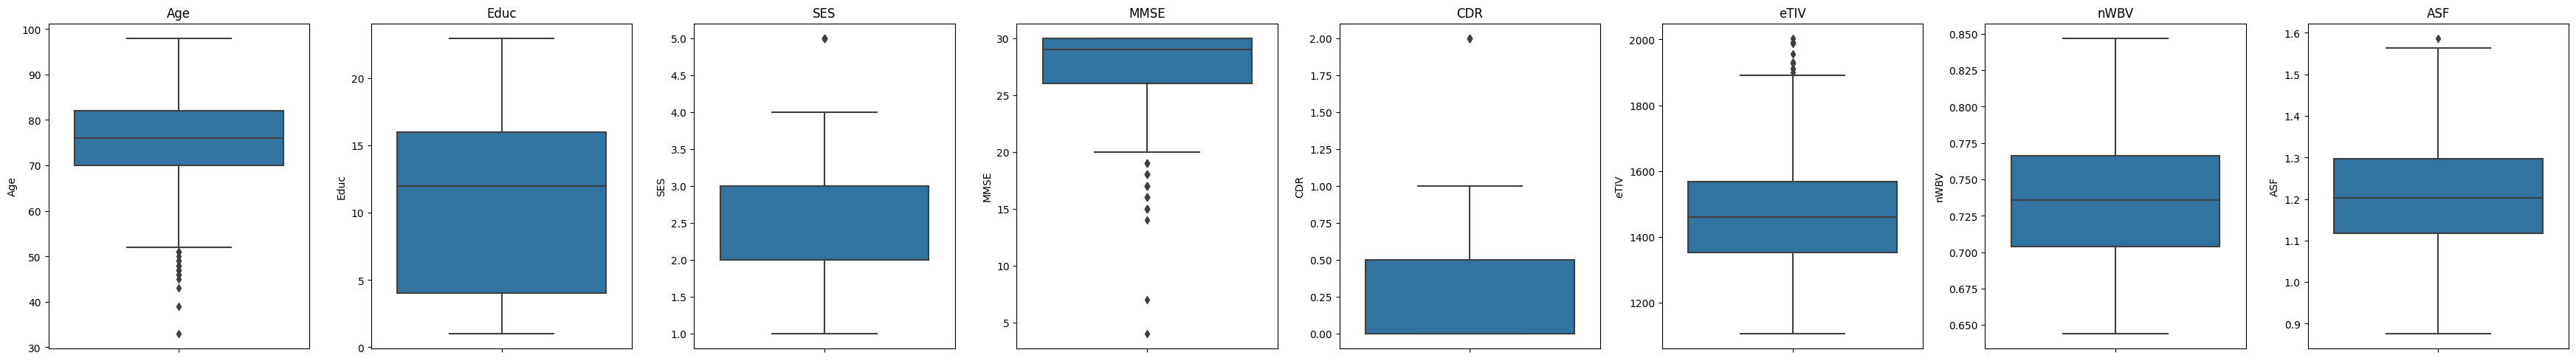

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
column_names = ['Age','Educ','SES','MMSE','CDR','eTIV','nWBV','ASF']
fig, axes = plt.subplots(nrows=1, ncols=len(column_names), figsize=(35, 5)) # Adjust figsize as needed

for i, col in enumerate(column_names):
    sns.boxplot(y=data[col], ax=axes[i])
    axes[i].set_title(col)  

plt.tight_layout()
plt.show()

<ipython-input-13-171ade5bf97a>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = data.corr()


<Axes: >

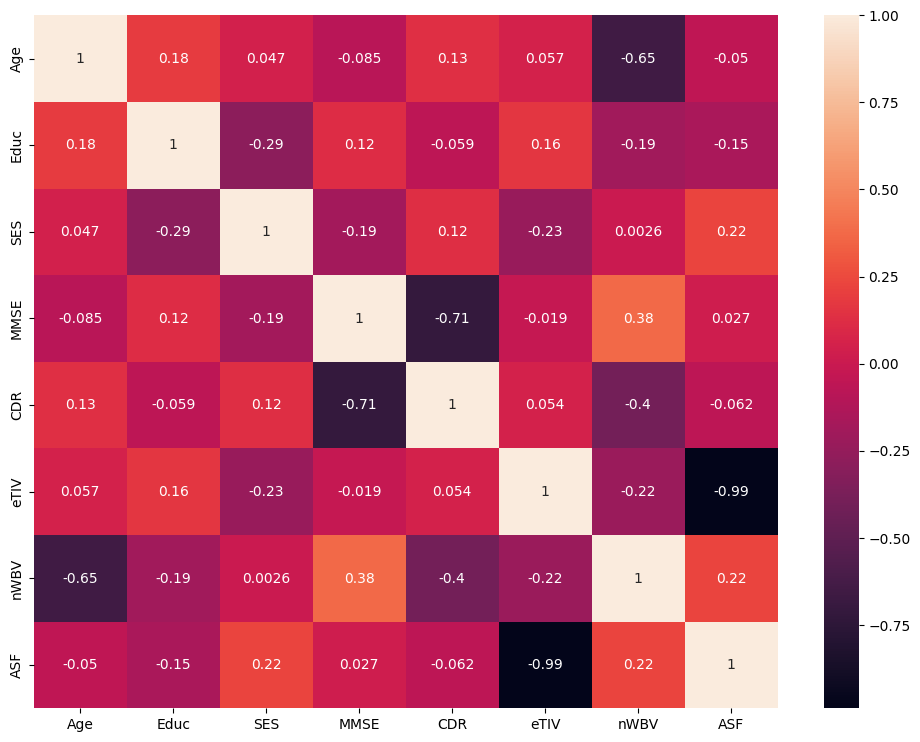

In [13]:
cor = data.corr()
plt.figure(figsize=(12,9))
sns.heatmap(cor, xticklabels=cor.columns.values,yticklabels=cor.columns.values, annot=True)


In [14]:
data.isna().sum()

M/F      0
Hand     0
Age      0
Educ     0
SES     38
MMSE     2
CDR      0
eTIV     0
nWBV     0
ASF      0
dtype: int64

In [15]:
data.dtypes

M/F      object
Hand     object
Age       int64
Educ    float64
SES     float64
MMSE    float64
CDR     float64
eTIV      int64
nWBV    float64
ASF     float64
dtype: object

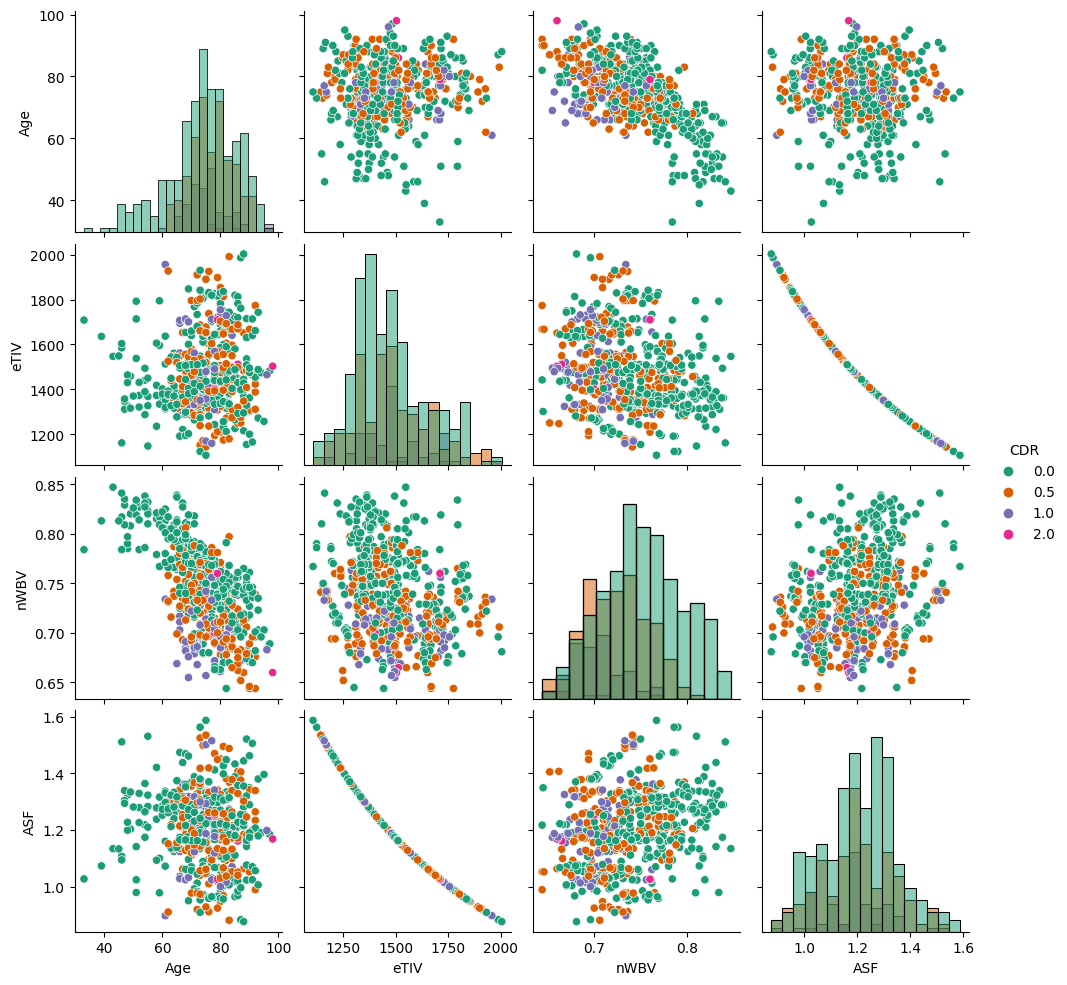

In [16]:
continous_features = ['Age','eTIV','nWBV','ASF','CDR']
custom_palette = ['red','blue','grey','green']
sns.pairplot(data[continous_features], hue='CDR', diag_kind='hist',palette='Dark2')

Lets look at the distributions of each varibles in respect to the target variable 'CDR'.

[Text(0, 0, 'Female'), Text(1, 0, 'Male')]

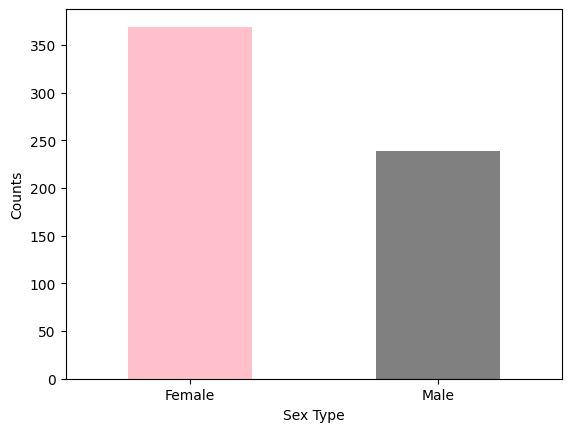

In [17]:
sex_counts = data['M/F'].value_counts()
colors = ['pink', 'grey']
fig,ax = plt.subplots()
ax = sex_counts.plot(kind='bar',xlabel='Sex Type',ylabel='Counts',color=colors)
ax.set_xticklabels(['Female', 'Male'], rotation=0)

Text(0, 0.5, 'Count')

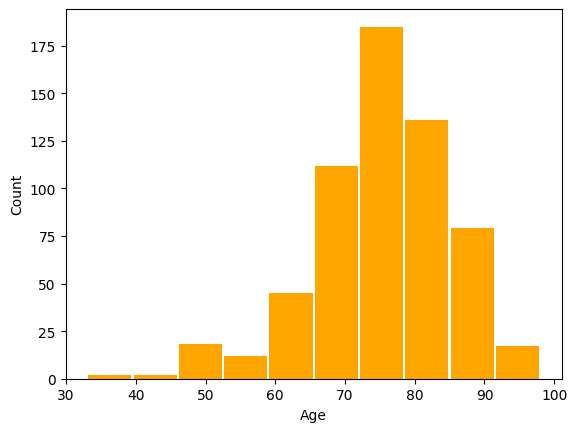

In [18]:
age_counts = data['Age'].value_counts()
fig,ax = plt.subplots()
ax.hist(data['Age'],bins=10,rwidth=0.95,color='orange')
ax.set_xlabel('Age')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

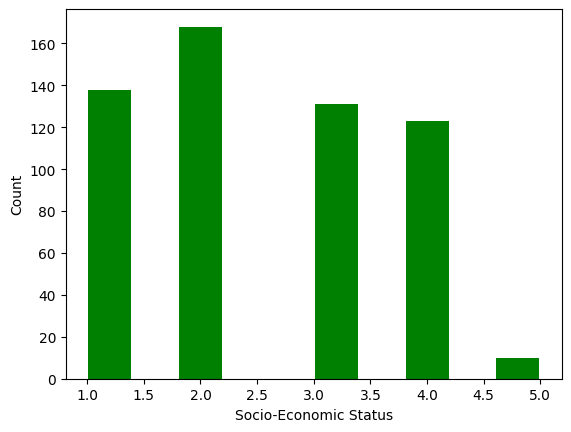

In [19]:
ses_counts = data['SES'].value_counts()
fig,ax = plt.subplots()
ax.hist(data['SES'],bins=10,rwidth=0.95,color='green')
ax.set_xlabel('Socio-Economic Status')
ax.set_ylabel('Count')

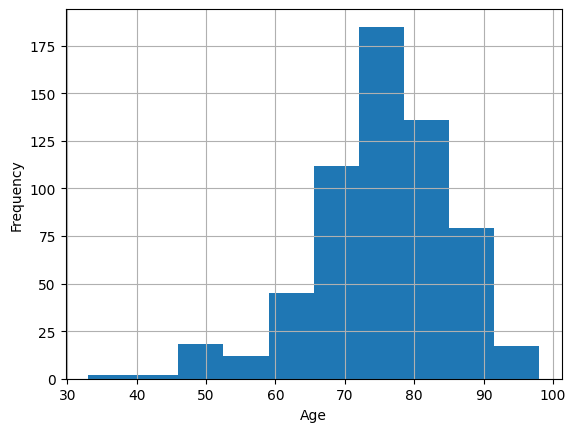

In [20]:
# TODO: write code to plot the distribution of age, race, and sex
# in this code cell

import matplotlib.pyplot as plt
import numpy as np

x = np.random.normal(170, 10, 250)

plt.hist(data["Age"])
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.grid()
plt.show()

## Imputing columns using SimpleImputer.
We fill in the missing values in the "SES" columns with the most occuring data element.
Similarly, we fill the missing values in the "MMSE" column with the median of that column.

In [21]:
from sklearn.impute  import SimpleImputer
imputer = SimpleImputer ( missing_values = np.nan,strategy='most_frequent')

imputer.fit(data[['SES']])
data[['SES']] = imputer.fit_transform(data[['SES']])

# We perform it with the median
imputer = SimpleImputer ( missing_values = np.nan,strategy='median')

imputer.fit(data[['MMSE']])
data[['MMSE']] = imputer.fit_transform(data[['MMSE']])

In [22]:
data

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
8,M,R,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
9,F,R,52,3.0,2.0,30.0,0.0,1321,0.827,1.329
...,...,...,...,...,...,...,...,...,...,...
368,M,R,82,16.0,1.0,28.0,0.5,1693,0.694,1.037
369,M,R,86,16.0,1.0,26.0,0.5,1688,0.675,1.040
370,F,R,61,13.0,2.0,30.0,0.0,1319,0.801,1.331
371,F,R,63,13.0,2.0,30.0,0.0,1327,0.796,1.323


In [23]:
for i, col_type in enumerate(data.dtypes):
    if col_type == "object":
        print("\nVariable {} takes the values: {}".format(
            data.columns[i],
            data[data.columns[i]].unique()))


Variable M/F takes the values: ['F' 'M']

Variable Hand takes the values: ['R']


## Encoding the Target variable using LabelEncoder.

In [24]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data['CDR'] = le.fit_transform(data['CDR'].values)

Converting categorical variables to numeric using OneHot encoding.

In [25]:
data = pd.get_dummies(data)

## Plotting the distribution of classes on a barplot.

<BarContainer object of 4 artists>

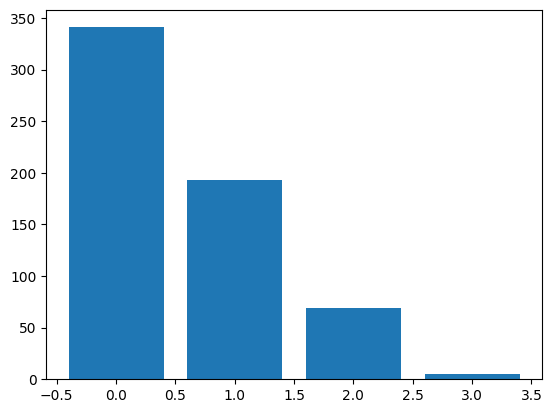

In [26]:
plt.bar(data['CDR'].unique(),data['CDR'].value_counts())

Neglecting the last class due to negligible size in the combined dataset.

In [27]:
data = data.drop(data[data['CDR']==3].index)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 599 entries, 0 to 372
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     599 non-null    int64  
 1   Educ    599 non-null    float64
 2   SES     599 non-null    float64
 3   MMSE    599 non-null    float64
 4   CDR     599 non-null    int64  
 5   eTIV    599 non-null    int64  
 6   nWBV    599 non-null    float64
 7   ASF     599 non-null    float64
 8   M/F_F   599 non-null    uint8  
 9   M/F_M   599 non-null    uint8  
 10  Hand_R  599 non-null    uint8  
dtypes: float64(5), int64(3), uint8(3)
memory usage: 43.9 KB


In [28]:
y = data.pop('CDR')
x = data

## Normalizing the data.
We observe that different columns have different ranges of values. We use Z-score normalization in this case.

In [29]:
x = StandardScaler().fit_transform(x)

## Dividing dataset into train and test sets.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42,test_size=0.3)

## Defining Models.



```
# This is formatted as code
```

### 1. We will try hyperparameter tuning using cross-validation for XGBClassifier.

In [31]:
from xgboost import XGBClassifier
FOLDS = 5

parametros_xgb = {
    "learning_rate": [0.01, 0.025, 0.005,0.5, 0.075, 0.1, 0.15, 0.2,0.3,0.8,0.9],
    "max_depth":[3,5,8,10,15,20,25,30,40,50],
    "n_estimators":range(1,1000)
    }

model_xgb= XGBClassifier(eval_metric='mlogloss')


xgb_random = RandomizedSearchCV(estimator = model_xgb, param_distributions = parametros_xgb, n_iter = 100, cv = FOLDS, 
                               verbose=0, random_state=42,n_jobs = -1, scoring='accuracy')
xgb_random.fit(X_train, y_train)

xgb_random.best_params_

{'n_estimators': 583, 'max_depth': 5, 'learning_rate': 0.5}

In [32]:
model_xgb = xgb_random.best_estimator_
model_xgb.fit(X_train,y_train)
model_xgb.score(X_test,y_test)

0.7722222222222223

### 2. Trying hyperparameter tuning of GradientBoostingClassifier.

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
FOLDS =10

parametros_gb = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.005,0.5, 0.075, 0.1, 0.15, 0.2,0.3,0.8,0.9],
    "min_samples_split": [0.01, 0.025, 0.005,0.4,0.5, 0.075, 0.1, 0.15, 0.2,0.3,0.8,0.9],
    "min_samples_leaf": [1,2,3,5,8,10,15,20,40,50,55,60,65,70,80,85,90,100],
    "max_depth":[3,5,8,10,15,20,25,30,40,50],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "squared_error"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":range(1,100)
    }

model_gb= GradientBoostingClassifier()


gb_random = RandomizedSearchCV(estimator = model_gb, param_distributions = parametros_gb, n_iter = 100, cv = FOLDS, 
                               verbose=0, random_state=42,n_jobs = -1, scoring='accuracy')
gb_random.fit(X_train, y_train)

gb_random.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


{'subsample': 0.95,
 'n_estimators': 68,
 'min_samples_split': 0.025,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 20,
 'loss': 'deviance',
 'learning_rate': 0.8,
 'criterion': 'squared_error'}

In [34]:
model_gb = gb_random.best_estimator_
print(model_gb.score(X_test,y_test))

0.8055555555555556


GradientBoosting model performs better than XGboost, Hence we try 10-fold cross validation on GradientBoostingClassifier model to improve accuracy.

In [35]:
cross_val_score(model_gb, x, y, cv=10, scoring='accuracy').mean()

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
 

0.8112994350282486

### Making predictions using the best estimator and plotting the confusion matrix along with classification report.

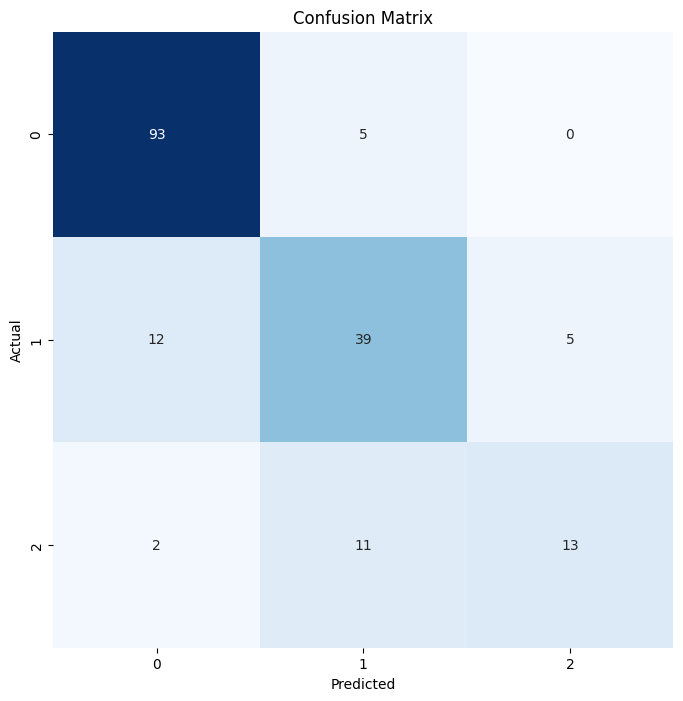

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.87      0.95      0.91        98
           1       0.71      0.70      0.70        56
           2       0.72      0.50      0.59        26

    accuracy                           0.81       180
   macro avg       0.77      0.72      0.73       180
weighted avg       0.80      0.81      0.80       180



In [36]:
y_pred = model_gb.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)


In [37]:
# Install DataSynthesizer
!pip install DataSynthesizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
# Import packages
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import read_json_file, display_bayesian_network

In [99]:
!wget -O combined.csv https://raw.githubusercontent.com/ads-predict-early-alzheimers/project/main/combined.csv

--2023-05-09 21:31:03--  https://raw.githubusercontent.com/ads-predict-early-alzheimers/project/main/combined.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25081 (24K) [text/plain]
Saving to: ‘combined.csv’

combined.csv        100%[===================>]  24.49K  --.-KB/s    in 0s      

2023-05-09 21:31:03 (64.1 MB/s) - ‘combined.csv’ saved [25081/25081]



In [100]:
# Intialize a describer and a generator
describer = DataDescriber()
generator = DataGenerator()

In [159]:
# Set up some paths
description_files = {'random mode':                   'description(random).json', 
                     'independent attribute mode':    'description(independent).json', 
                     'correlated attribute mode':     'description(correlated).json'}
synthetic_data_files = {'random mode':                'synthetic data(random).csv', 
                        'independent attribute mode': 'synthetic data(independent).csv', 
                        'correlated attribute mode':  'synthetic data(correlated).csv'}

output_data_size = 1000

In [160]:
sensitive_data_file = 'combined.csv'

In [161]:
real_data = pd.read_csv(sensitive_data_file)
real_data.head()

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
3,M,R,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
4,F,R,52,3.0,2.0,30.0,0.0,1321,0.827,1.329


## Random mode

In random mode, we replace the feature(s) that we want to protect with random values drawn from a uniform distribution:

In [162]:
describer.describe_dataset_in_random_mode(sensitive_data_file)

In [163]:
describer.save_dataset_description_to_file(description_files['random mode'])

#### Important parameters in random mode

Let's generate synthetic data in random mode. Pay attention to these parameters:

- __seed__: initialize the random number generator for both `random` and `np.random`
- __mininum__, __maximum__: determines the min and max of the random distribution from which we will draw the new values

In [164]:
generator.generate_dataset_in_random_mode(n=output_data_size, 
                                          description_file=description_files['random mode'], 
                                          seed=0, 
                                          minimum=0, 
                                          maximum=100)

Now let's save the synthetic data, read it as a pandas dataframe, and look at the data:

In [165]:
generator.save_synthetic_data(synthetic_data_files['random mode'])

In [166]:
synthetic_random = pd.read_csv(synthetic_data_files['random mode'])

In [167]:
real_data.head()

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
3,M,R,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
4,F,R,52,3.0,2.0,30.0,0.0,1321,0.827,1.329


In [168]:
synthetic_random.head()

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,F,R,39,8.0,4.0,29.0,0.5,3,69.827870,16.999181
1,M,R,28,20.0,4.0,19.0,2.0,74,10.422642,36.197822
2,M,R,24,12.0,3.0,14.0,0.0,41,79.299988,29.004372
3,F,R,18,6.0,1.0,18.0,2.0,39,46.230787,14.093879
4,M,R,67,13.0,2.0,23.0,0.0,96,7.951784,66.883433


__Compare the two dataframes above (the real data and synthetic data we just generated):__
1. Look at the rows; how do the values of the real data and synthetic data compare?
ANS: The number of rows is the same in both the real and artificial datasets, and the variables in the artificial dataset are comparable but not exactly the same as those in the real dataset. For example, the means and standard deviations of age and education in both datasets are similar, but not precisely identical.
2. Do we need to consider something else apart from whether a particular value differs?
ANS: Aside from assessing differences in values, it is essential to consider the overall distribution of the variables and the accuracy of the patterns reflected in the synthetic data. Various visualization methods such as histograms and density plots can help in examining the distribution of each variable. Moreover, statistical tests can aid in identifying any significant variations between the two datasets. It is also important to contemplate the possible impacts of any disparities or dissimilarities between the real and generated data on the analysis or decision-making that will rely on the generated data.

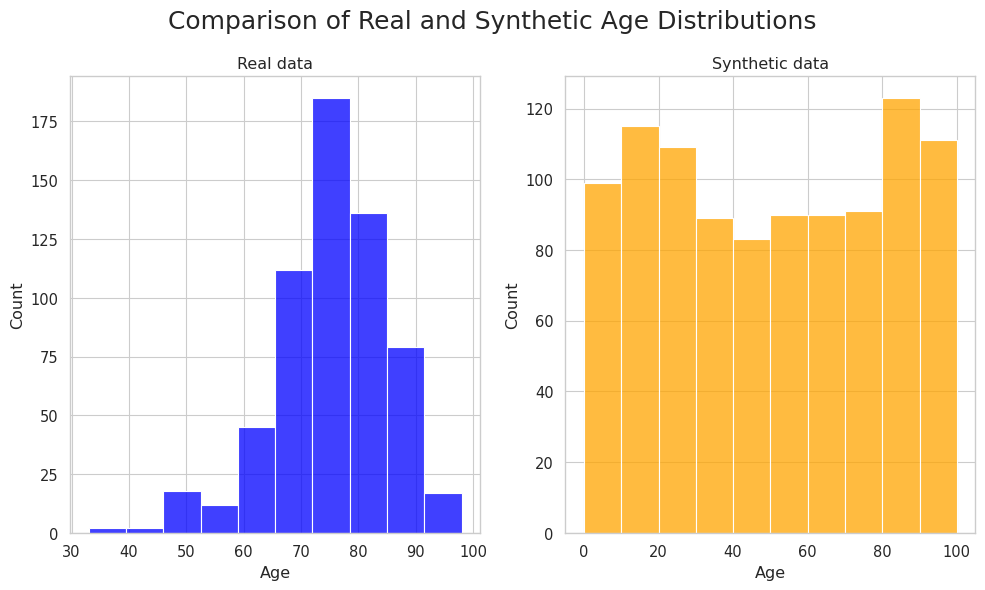

In [169]:
# plot the distribution of age in real_data and in synthetic_random
# write your code here
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

fig, axs = plt.subplots(ncols=2, figsize=(10, 6))

sns.histplot(data=real_data, x='Age', ax=axs[0], bins=10, color='blue')
sns.histplot(data=synthetic_random, x='Age', ax=axs[1], bins=10, color='orange')

axs[0].set(title='Real data', xlabel='Age', ylabel='Count')
axs[1].set(title='Synthetic data', xlabel='Age', ylabel='Count')

fig.suptitle('Comparison of Real and Synthetic Age Distributions', fontsize=18)
plt.tight_layout()

plt.show()

In [170]:
# compare the frequency of the different values of cdr status in real_data and synthetic_data (you can use a table and/or plots)
# write your code here
import pandas as pd

real_cdr_counts = pd.Series(real_data['CDR']).value_counts()
synthetic_cdr_counts = pd.Series(synthetic_random['CDR']).value_counts()


In [171]:
real_cdr_counts = pd.Series(real_data['CDR']).value_counts()
synthetic_cdr_counts = pd.Series(synthetic_random['CDR']).value_counts()

data_combined = pd.DataFrame({
    'real_data': real_cdr_counts,
    'synthetic_data': synthetic_cdr_counts
})
data_combined

,real_data,synthetic_data
0.0,341,275
0.5,193,284
1.0,69,208
2.0,5,233


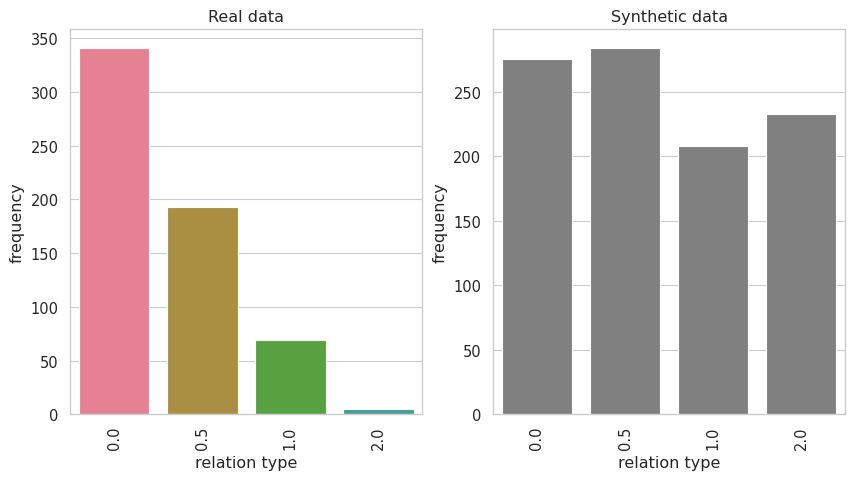

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)

sns.barplot(x=real_cdr_counts.index, y=real_cdr_counts.values, ax=ax[0])
sns.barplot(x=synthetic_cdr_counts.index, y=synthetic_cdr_counts.values, ax=ax[1], color='gray')

ax[0].set(xlabel='relation type', ylabel='frequency', title='Real data')
ax[1].set(xlabel='relation type', ylabel='frequency', title='Synthetic data')

# Set x-axis label orientation to 90 degrees
ax[1].tick_params(axis='x', labelrotation=90)
ax[0].tick_params(axis='x', labelrotation=90)

plt.show()


We can pull more information on how the cdr feature is generated in random mode using the describer functions:

In [173]:
with open(description_files['random mode']) as f:
    description_json = json.load(f)

In [174]:
description_json.keys()

dict_keys(['meta', 'attribute_description', 'bayesian_network', 'conditional_probabilities'])

In [175]:
print(json.dumps(description_json['attribute_description']['CDR'], indent=4))

{
    "name": "CDR",
    "data_type": "Float",
    "is_categorical": true,
    "is_candidate_key": false,
    "min": 0.0,
    "max": 2.0,
    "missing_rate": 0.0,
    "distribution_bins": [
        0.0,
        0.5,
        1.0,
        2.0
    ],
    "distribution_probabilities": [
        0.25,
        0.25,
        0.25,
        0.25
    ]
}


## Independent attribute mode

In independent attribute mode, we replace the feature we want to protect with values that follow the same distribution as the original data. However, we do not consider any other features when determining the new value for the sensitive feature. 

In [176]:
describer.describe_dataset_in_independent_attribute_mode(sensitive_data_file, epsilon=0.1)

In [177]:
describer.save_dataset_description_to_file(description_files['independent attribute mode'])

Use ``generator.generate_dataset_in_independent_mode`` to generate synthetic data using the independent attribute mode. Hint: Look at the ``generate_dataset_in_random_mode`` code above if you are unsure how to proceed. You should set a seed, but you do not need to set a minimum or maximum:

In [178]:
# generate synthetic data in independent attribute mode
# write your code here using: generator.generate_dataset_in_independent_mode
generator.generate_dataset_in_independent_mode(n=output_data_size, 
                                          description_file=description_files['independent attribute mode'], 
                                          seed=0)

Now let's save the synthetic data we just generated in independent attribute mode, read it as a pandas dataframe, and view it:

In [179]:
generator.save_synthetic_data(synthetic_data_files['independent attribute mode'])

In [180]:
synthetic_independent = pd.read_csv(synthetic_data_files['independent attribute mode'])

In [181]:
synthetic_independent.head()

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,M,R,75.0,14.0,2.0,19.0,0.5,1687.0,0.778067,1.234962
1,M,R,74.0,16.0,2.0,19.0,0.5,1637.0,0.775147,1.579475
2,M,R,73.0,16.0,2.0,14.0,1.0,1814.0,0.828698,1.496460
3,M,R,66.0,16.0,2.0,19.0,1.0,1903.0,0.737222,0.987226
4,M,R,74.0,16.0,2.0,19.0,0.0,1114.0,0.676265,0.980303


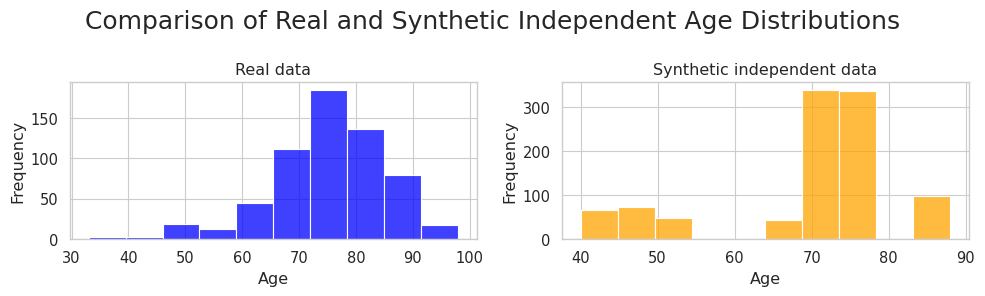

In [182]:
# Plot the distribution of age before and after being protected using independent attribute mode (i.e. in real_data and in synthetic_independent)
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=2, figsize=(10, 3), dpi=100)

sns.histplot(data=real_data, x='Age', ax=axs[0], bins=10, color="blue")
sns.histplot(data=synthetic_independent, x='Age', ax=axs[1], bins=10, color="orange")

axs[0].set(title='Real data', xlabel='Age', ylabel='Frequency')
axs[1].set(title='Synthetic independent data', xlabel='Age', ylabel='Frequency')

fig.suptitle('Comparison of Real and Synthetic Independent Age Distributions', fontsize=18)
plt.tight_layout()

plt.show()

[Text(0.5, 1.0, 'Synthetic data distribution'),
 Text(0.5, 0, 'Age'),
 Text(0, 0.5, 'Frequency')]

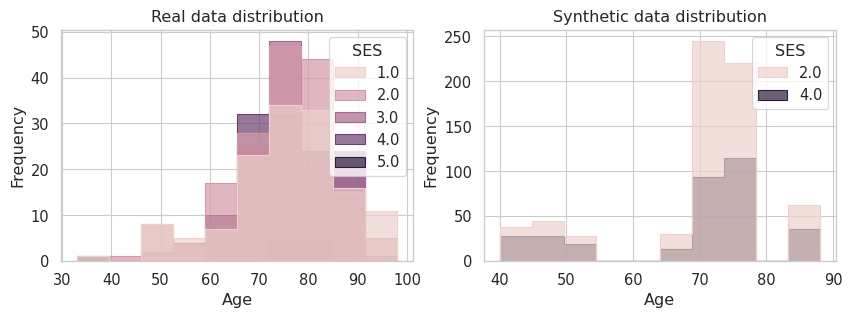

In [183]:
# Now plot the distribution of age by SES group in the real data and in the synthetic data.
# Each plot should contain a histogram of age for all rows where income >50K and a histogram for age where income <=50k.
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(10, 3), dpi=100)

sns.histplot(real_data, x='Age', hue='SES', bins=10, element='step', alpha=0.7, ax=axes[0])
sns.histplot(synthetic_independent, x='Age', hue='SES', bins=10, element='step', alpha=0.7, ax=axes[1])

axes[0].set(title='Real data distribution', xlabel='Age', ylabel='Frequency')
axes[1].set(title='Synthetic data distribution', xlabel='Age', ylabel='Frequency')

How do these distributions compare?

**Write your answer in this text cell:**
The visualizations presented here compare the age distribution by income for both real data and synthetic data generated using the independent attribute mode. Notably, the synthetic data distribution closely resembles the actual data distribution, indicating a high representation of the real scenario. This result contrasts with those obtained from randomly generated data.

In independent attribute mode, attribute generation occurs independently, without accounting for any correlation between attributes. Instead, individual attribute distributions are maintained. It is worth noting that correlation values between the artificial and real datasets may differ.

Overall, our model performs better with independent attribute mode than random mode.

Let's look at the distribution of cdr values in the real data and in the synthetic data generated using the independent attribute mode:

In [184]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_palette('husl')
sns.set_context('paper', font_scale=1.2)

cdr_real = real_data['CDR'].value_counts()
cdr_independent = synthetic_independent['CDR'].value_counts()

cdr_both = pd.merge(cdr_real.to_frame(),
                             cdr_independent.to_frame(),
                             left_index=True,
                             right_index=True,
                             suffixes=('_real', '_independent_attribute_mode'))


In [185]:
cdr_real

0.0    341
0.5    193
1.0     69
2.0      5
Name: CDR, dtype: int64

In [186]:
cdr_both

,CDR_real,CDR_independent_attribute_mode
0.0,341,197
0.5,193,292
1.0,69,511


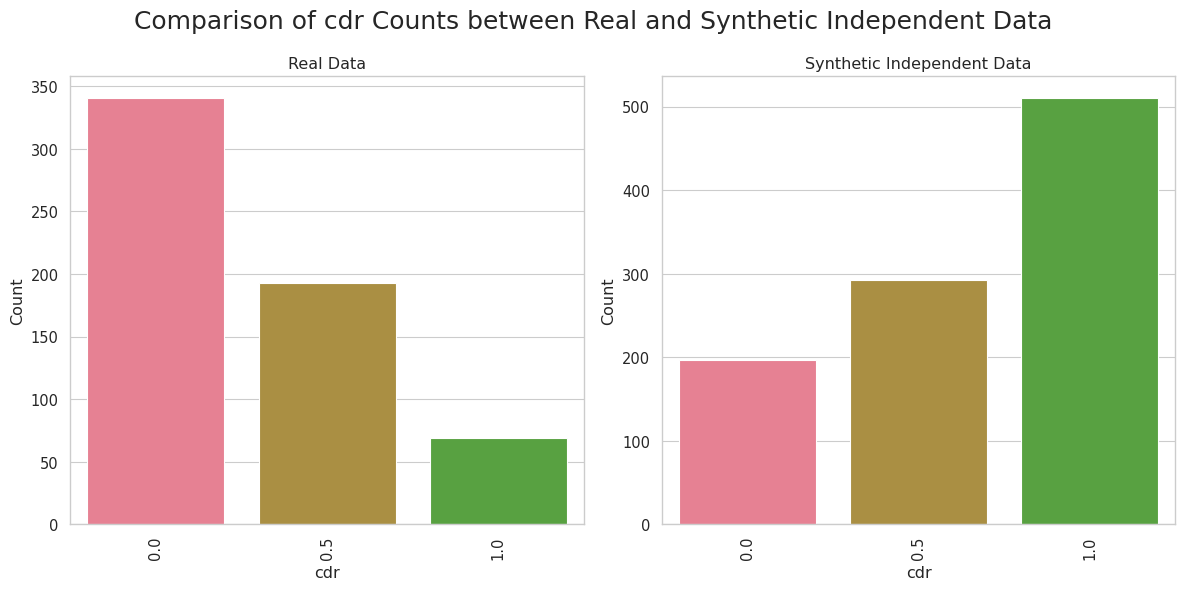

In [187]:

fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

sns.barplot(x=cdr_both.index, y='CDR_real', data=cdr_both, ax=axs[0])
sns.barplot(x=cdr_both.index, y='CDR_independent_attribute_mode', data=cdr_both, ax=axs[1])

axs[0].set(title='Real Data', xlabel='cdr', ylabel='Count')
axs[1].set(title='Synthetic Independent Data', xlabel='cdr', ylabel='Count')

for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

fig.suptitle('Comparison of cdr Counts between Real and Synthetic Independent Data', fontsize=18)
plt.tight_layout()

plt.show()

## Correlated attribute mode

The correlated attribute mode replaces the feature we want to protect with values based on the *conditional* distribution of all the features in the database. This is calculated using a Bayesian network.

In [188]:
describer.describe_dataset_in_correlated_attribute_mode(sensitive_data_file, 
                                                        epsilon=0.1, 
                                                        k=2)

================ Constructing Bayesian Network (BN) ================
Adding ROOT CDR
Adding attribute SES
Adding attribute eTIV
Adding attribute MMSE
Adding attribute Educ
Adding attribute Age
Adding attribute nWBV
Adding attribute Hand
Adding attribute ASF
Adding attribute M/F
========================== BN constructed ==========================


/usr/local/lib/python3.10/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


In [189]:
display_bayesian_network(describer.bayesian_network)

Constructed Bayesian network:
    SES  has parents ['CDR'].
    eTIV has parents ['SES', 'CDR'].
    MMSE has parents ['eTIV', 'CDR'].
    Educ has parents ['MMSE', 'CDR'].
    Age  has parents ['MMSE', 'CDR'].
    nWBV has parents ['Educ', 'eTIV'].
    Hand has parents ['MMSE', 'SES'].
    ASF  has parents ['Age', 'Educ'].
    M/F  has parents ['ASF', 'nWBV'].


In [190]:
describer.save_dataset_description_to_file(description_files['correlated attribute mode'])

Use generator.generate_dataset_in_correlated_attribute_mode to generate synthetic data using the correlated attribute mode:

In [191]:
# generate synthetic data in correlated attribute mode
# write your code here using: generator.generate_dataset_in_correlated_attribute_mode
generator.generate_dataset_in_correlated_attribute_mode(n=output_data_size, 
                                          description_file=description_files['correlated attribute mode'], 
                                          seed=0)

Again, save the data and read it as a pandas dataframe:

In [192]:
generator.save_synthetic_data(synthetic_data_files['correlated attribute mode'])

In [193]:
synthetic_correlated = pd.read_csv(synthetic_data_files['correlated attribute mode'])

Plot the distribution of age in the real data and synthetic data that you generated using the correlated attribute mode:

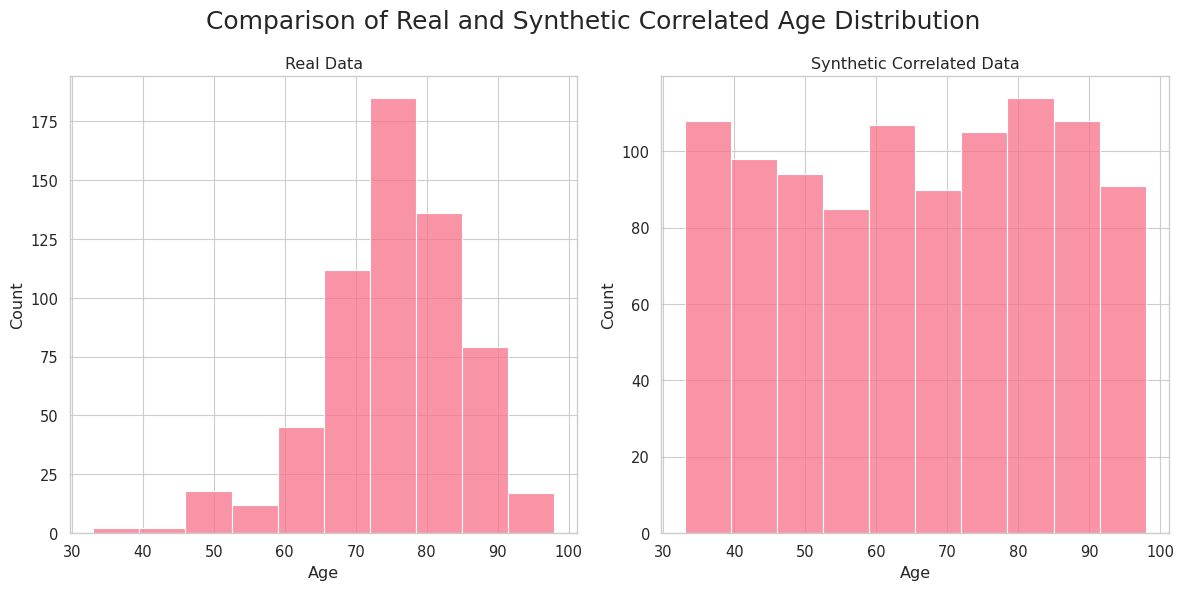

In [194]:
# plot the distribution of age in the real data and synthetic_correlated

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_palette('husl')
sns.set_context('paper', font_scale=1.2)

fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

sns.histplot(data=real_data, x='Age', bins=10, ax=axs[0])
sns.histplot(data=synthetic_correlated, x='Age', bins=10, ax=axs[1])

axs[0].set(title='Real Data', xlabel='Age', ylabel='Count')
axs[1].set(title='Synthetic Correlated Data', xlabel='Age', ylabel='Count')

fig.suptitle('Comparison of Real and Synthetic Correlated Age Distribution', fontsize=18)
plt.tight_layout()

plt.show()

#### Plot the cdr between two variables to see if changes after protecting age





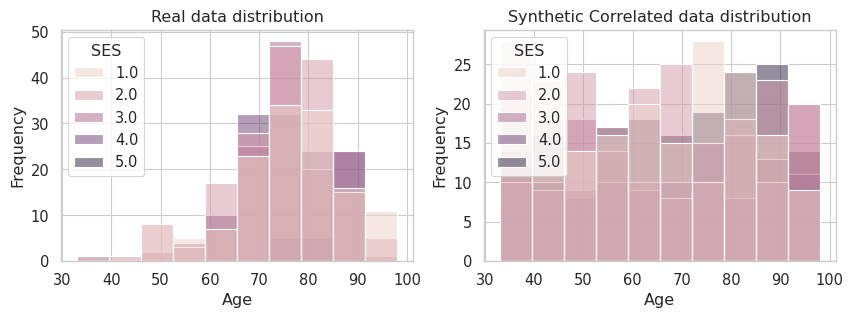

In [195]:
# write code here to plot the distribution of one variable by another variable
# in the real data and in synthetic_correlated
# e.g. plot age by education or age by income

import seaborn as sns

def plot_distribution(var1,var2):
    fig, ax = plt.subplots(1,2,figsize=(10,3),dpi=100)
    sns.histplot(real_data, x=var1, hue=var2, bins=10, ax=ax[0])
    sns.histplot(synthetic_correlated, x=var1, hue=var2, bins=10, ax=ax[1])
    ax[0].set(title='Real data distribution', xlabel=var1, ylabel='Frequency')
    ax[1].set(title='Synthetic Correlated data distribution', xlabel=var1, ylabel='Frequency')

plot_distribution('Age','SES')



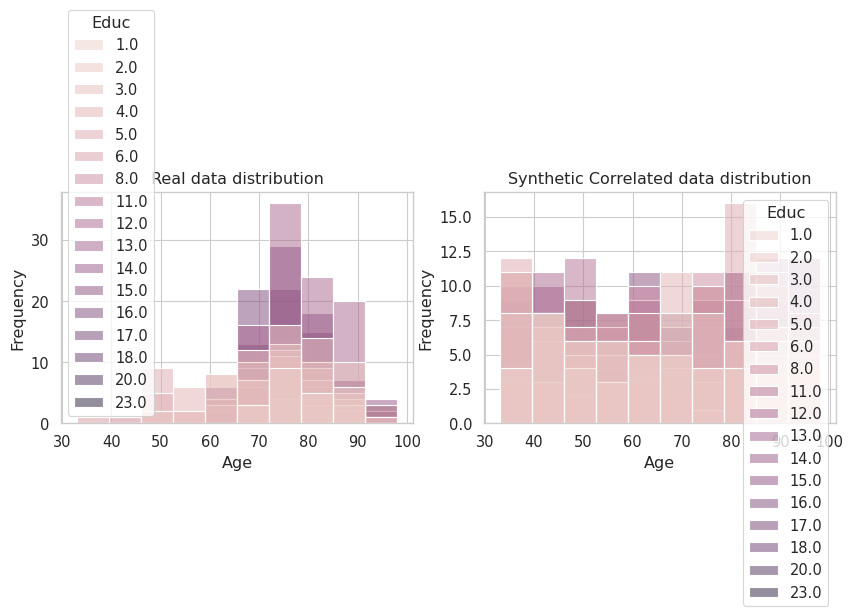

In [196]:
plot_distribution('Age','Educ')


__Write down your observations here:__

__Are there differences in the distributions of the data generated by the correlated attribute mode and the independent attribute mode?__

ANS: This plot's distributions illustrate the age distribution by income for both actual data and fake data created using the independent attribute method. We can see from a comparison of the two histograms that the synthetic data distribution closely resembles the actual data distribution. This suggests that as compared to the randomly generated dataset, the synthetic dataset produced using independent attribute mode represents the real scenario more accurately.

It is crucial to remember that the independent attribute mode does not randomly distribute or assign each attribute an equal probability. Instead, it creates the traits independently of one another, keeping track of each attribute's unique distribution and disregarding any association between them. As a result, the independent attribute mode-generated synthetic dataset can have a different correlation.

This synthetic dataset might have different correlation values than the real dataset. In our model it is giving better results than random mode. As a result, the independent attribute mode-generated synthetic dataset can have different correlation values than the actual dataset. Yet, in our model, this mode yields superior outcomes to the random mode.

In [197]:
import seaborn as sns

cdr_real = real_data['CDR'].value_counts()
cdr_independent = synthetic_independent['CDR'].value_counts()
cdr_both = pd.merge(cdr_real.to_frame(), 
                             cdr_independent.to_frame(), 
                             left_index=True, 
                             right_index=True, 
                             suffixes=('_real', '_independent_attribute_mode'))


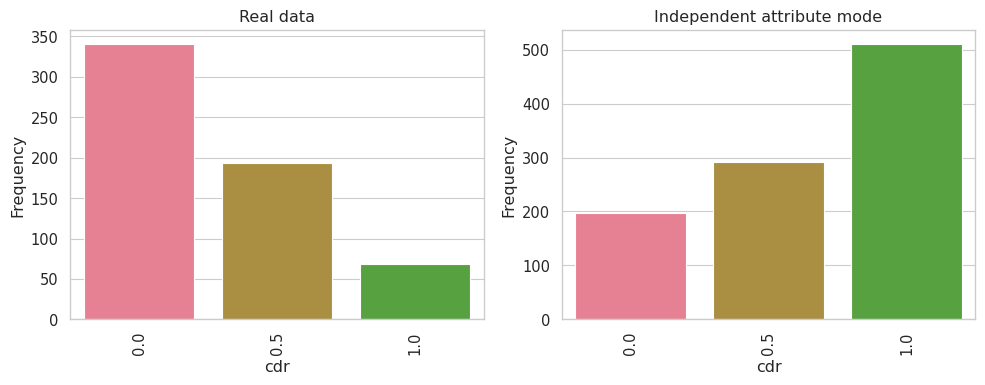

In [198]:
# plot the distribution of "cdr" in the synthetic data generated under the correlated attribute mode and the independent attribute mode here
fig, axes = plt.subplots(1, 2, figsize=(10,4), dpi=100)

sns.barplot(x=cdr_both.index, y=cdr_both['CDR_real'], ax=axes[0])
sns.barplot(x=cdr_both.index, y=cdr_both['CDR_independent_attribute_mode'], ax=axes[1])

axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)

axes[0].set(title='Real data', xlabel='cdr', ylabel='Frequency')
axes[1].set(title='Independent attribute mode', xlabel='cdr', ylabel='Frequency')

plt.tight_layout()
plt.show()

## Statistical measures

### Mutual information

We can use mutual information to further understand how the cdrs between features are similar/different in the real data and the synthetic data. Mutual information is defined as follows for two discrete variables X and Y:


$$I(X; Y) = \sum_{y \in Y} \sum_{x \in X} p(x,y) \log(\frac{p(x,y)}{p(x)p(y)})$$

Higher values indicate greater levels of mutual information. For two independent variables, the value will be zero (look at the logged term). This metric works for categorical variables *or* continuous variables. 

In [199]:
from sklearn.metrics import normalized_mutual_info_score

In [200]:
normalized_mutual_info_score(real_data['Age'], 
                             real_data['CDR'], 
                             average_method='arithmetic')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


0.0687772404047428

In [201]:
normalized_mutual_info_score(real_data['Age'], 
                             real_data['Educ'], 
                             average_method='arithmetic')

0.16672968682783296

We can even plot the mutual information between all pairs of features in the dataset:

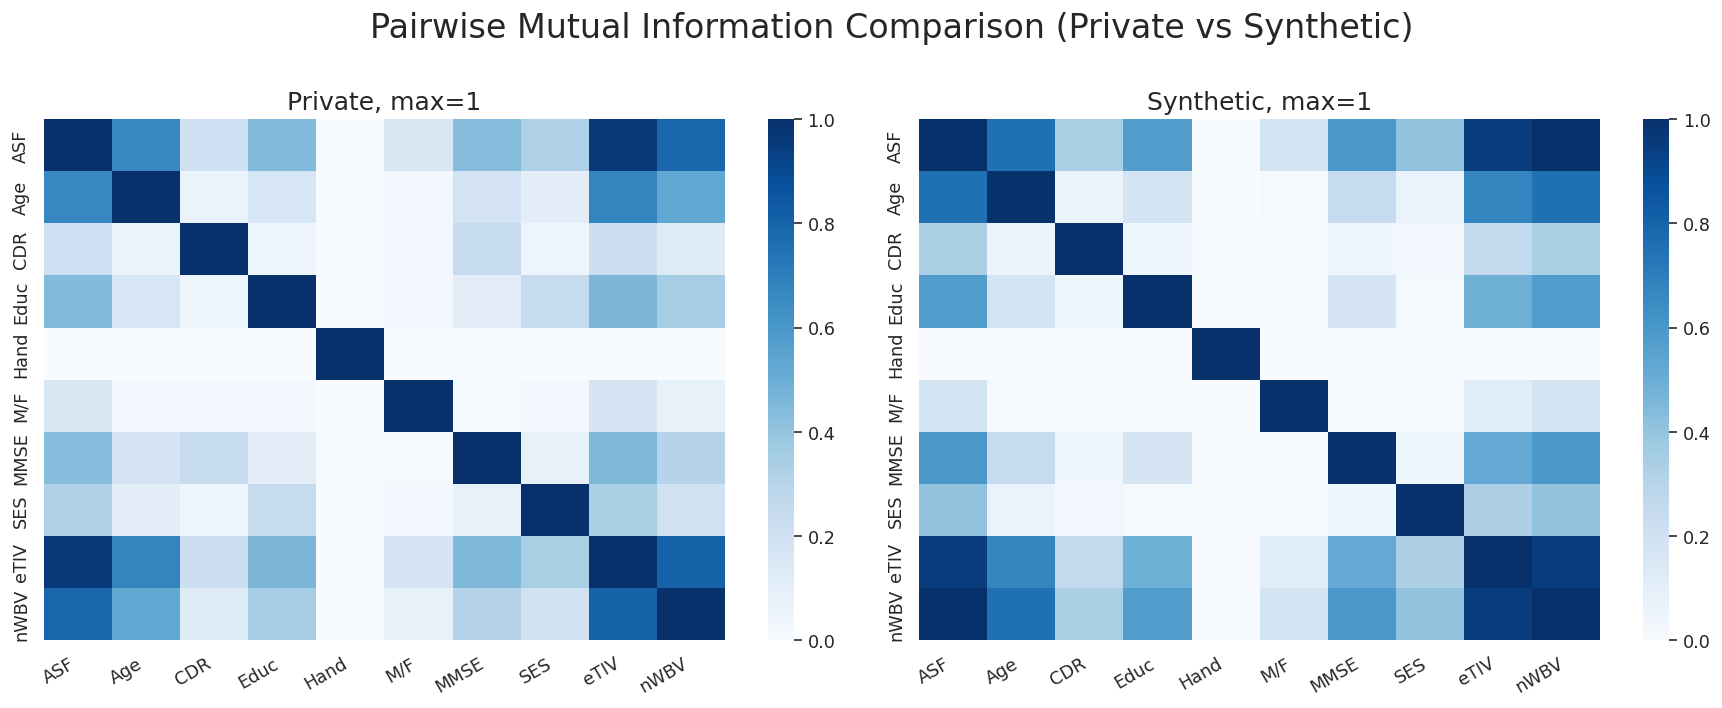

In [202]:
attribute_description = read_json_file(description_files['correlated attribute mode'])['attribute_description']
ModelInspector(real_data, 
               synthetic_correlated, 
               attribute_description).mutual_information_heatmap()

### Two-sample Kolmogorov–Smirnov test

The Kolmogorov-Smirnov test quantifies the similarity between the empirical distribution functions two sets of data. We can use it to measure how well the distribution of our synthetic data mimics the distribution of the original dataset. 

For two empirical distributions P and Q, the Kolmogorov–Smirnov test statistic is defined as:

$$D = \max_x |P(x) - Q(x)|$$

Intuitively, think of plotting the CDF of each dataset. The Kolmogorov–Smirnov test statistic is the maxium distance between the two CDFs. 

<img src="https://upload.wikimedia.org/wikipedia/commons/c/cf/KS_Example.png">

This metric only works for continuous variables. 

In [203]:
from scipy.stats import ks_2samp

In [204]:
def ks_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for Two-sample Kolmogorov–Smirnov test.
    """
    return ks_2samp(df_in[attr], df_out[attr])[0]

In [205]:
ks_test(real_data, synthetic_random, 'Age')

0.5265657894736843

In [206]:
ks_test(real_data, synthetic_independent, 'Age')

0.40628947368421053

In [207]:
ks_test(real_data, synthetic_correlated, 'Age')

0.36206578947368423

What do you notice about the Kolmogorov–Smirnov test statistic in the synthetic_random versus the synthetic_independent and synthetic_correlated modes?

**Write your observations in this text cell:** According to the K-S test, there may be a significant difference between the distributions of the two datasets if the Kolmogorov-Smirnov test statistic's value is high. Here, we observe that the value is extremely high for synthetic random mode data, although it is about the same for independent and correlated data. The independent mode dataset that was generated, not the correlated data, has the lowest value. This indicates that there was little association between the attributes in the actual dataset (no connection between the columns). Hence, the dataset produced utilizing attribute independence produced better outcomes. It is important to note that the age property was used to calculate these results. For accurate comparisons across various modes, we must also compare other column distributions ( random, independent and correlated ).

The effectiveness of models trained on these artificial datasets and models trained on real datasets can be contrasted. We can evaluate the precision, recall, and other metrics.

### KL-divergence

The KL-divergence is an alternative way to measure the difference between two distributions. For two distributions P and Q, the KL-divergence is defined as 

$$D = \sum_x P(x) \log (\frac{P(x)}{Q(X)})$$

This metric works on discrete/categorical variables.


In [208]:
from scipy.stats import entropy

In [209]:
def get_distribution_of_categorical_attribute(attribute: pd.Series, indicies=None):
    distribution = attribute.dropna().value_counts()
    if indicies is not None:
        for idx in set(indicies) - set(distribution.index):
            distribution.loc[idx] = 0
    distribution.sort_index(inplace=True)
    return distribution/sum(distribution)

def kl_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for KL-divergence.
    """
    distribution_in = get_distribution_of_categorical_attribute(df_in[attr])
    distribution_out = get_distribution_of_categorical_attribute(df_out[attr], distribution_in.index)
    return entropy(distribution_out, distribution_in)

In [210]:
kl_test(real_data, synthetic_random, 'CDR')

0.6775753372834721

In [211]:
kl_test(real_data, synthetic_independent, 'CDR')

0.5383929013675659

In [212]:
kl_test(real_data, synthetic_correlated, 'CDR')

1.0117168697957206

### Boxplot

It is often useful to the compare distributions of a continuous variable using a boxplot. For example, we plot the distribution of age by income status in the real data and in the synthetic_correlated data below:

In [213]:
import seaborn as sns

In [214]:
real_data.head()

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
3,M,R,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
4,F,R,52,3.0,2.0,30.0,0.0,1321,0.827,1.329


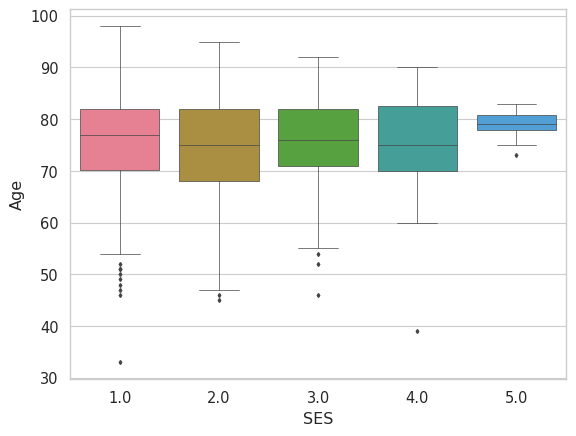

In [215]:
plt.figure(dpi=100)
sns.boxplot(x='SES', y='Age', data=real_data, linewidth=0.5, fliersize=2);

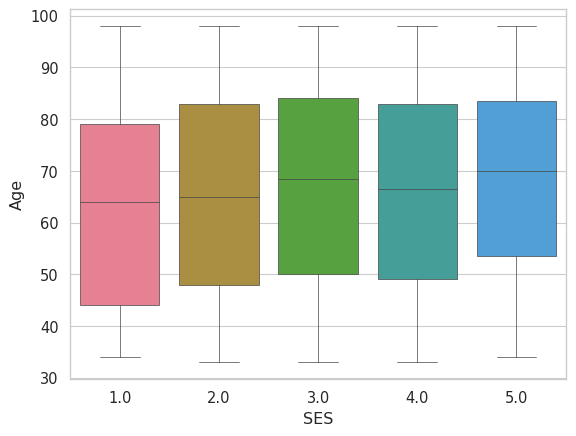

In [216]:
plt.figure(dpi=100)
sns.boxplot(x='SES', y='Age', data=synthetic_correlated, linewidth=0.5, fliersize=2);